In [1]:
from PIL import Image, ImageDraw, ImageFont, ImageOps
import string
import random
import cv2
import re
import os
import numpy as np
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont, ImageOps
from scipy import ndimage
import string
from read_classic import metrics
import random
import cv2
import re
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import cm
from generate.characters_generate import generate_characters
from generate.plates_generate import create_plates
from train_model_characters import create_and_train_model, convert_to_text
from utils import load_bw_images_dict_from_folder

In [2]:
# NEW
def get_center(rect):
    return rect[0], rect[1]

In [3]:

def split_in_two_lines(rects, deviation):
    for first_line_first_index in range(0, len(rects)):
        for first_line_second_index in range(0, len(rects)):
            if first_line_first_index != first_line_second_index:
                first_line_rect_indices = [first_line_first_index, first_line_second_index]
                line_1_rects = [rects[first_line_rect_indices[0]], rects[first_line_rect_indices[1]]]
                second_line_rect_indices = []
                line_2_rects = []

                point1 = get_center(line_1_rects[0])
                point2 = get_center(line_1_rects[1])
                eps = 10 ^ (-5)

                line_1_m = (point2[1] - point1[1]) / (point2[0] - point1[0] + eps)
                line_1_b = point1[1] - (line_1_m * point1[0])
                line_2_m = 0
                line_2_b = 0

                are_two_parallel_lines = True

                for i in range(0, len(rects)):
                    center = get_center(rects[i])

                    if i in first_line_rect_indices or i in second_line_rect_indices:
                        continue
                    else:
                        line_1_y = line_1_m * center[0] + line_1_b
                        line_2_y = line_2_m * center[0] + line_2_b

                        if abs(center[1] - line_1_y) < deviation:
                            line_1_rects.append(rects[i])
                            first_line_rect_indices.append(i)
                        elif len(line_2_rects) > 1:
                            if abs(center[1] - line_2_y) < deviation:
                                line_2_rects.append(rects[i])
                                second_line_rect_indices.append(i)
                            else:
                                are_two_parallel_lines = False
                                break
                        else:
                            line_2_rects.append(rects[i])
                            second_line_rect_indices.append(i)
                            point = get_center(line_2_rects[0])
                            line_2_m = line_1_m
                            line_2_b = point[1] - (line_2_m * point[0])

                if are_two_parallel_lines:
                    if line_1_b < line_2_b:
                        return line_1_rects, line_2_rects
                    else:
                        return line_2_rects, line_1_rects
                    
    print("Something went wrong, 2liner didnt find correct answer")
    print(rects, deviation)
    return line_1_rects, line_2_rects

In [4]:

def get_box_points(x, y, w, h, alpha):
    return cv2.boxPoints(((x, y), (w, h), alpha))

In [5]:
# Fix the wrong formula (now rects are rotated, so formula for x2, y2 is wrong)
# NEW
def remove_overlapping_bounding_rects(bounding_rects, overlap_percent):
        overlapped_indices = []
        max_idx = len(bounding_rects)
        for chosen_rect_idx in range(0, max_idx):
            x1, y1, w1, h1, alpha1 = bounding_rects[chosen_rect_idx]
            area1 = w1 * h1
            for j in range(chosen_rect_idx, max_idx):
                if chosen_rect_idx != j:
                    x2, y2, w2, h2, alpha2 = bounding_rects[j]
                    x_overlap = max(0, min(x1 + w1/2, x2 + w2/2) - max(x1-w1/2, x2-w2/2))
                    y_overlap = max(0, min(y1 + h1/2, y2 + h2/2) - max(y1-h1/2, y2-h2/2))
                    area_overlap = x_overlap * y_overlap
                    area2 = w2 * h2
                    if area_overlap > overlap_percent * min(area1, area2):
                        if area1 < area2:
                            overlapped_indices.append(chosen_rect_idx)
                        else:
                            overlapped_indices.append(j)
        k = len(bounding_rects)
        overlapped_indices = list(dict.fromkeys(overlapped_indices))
        np_output = np.array(bounding_rects)
        np_output = np.delete(np_output, overlapped_indices, 0)
        return np_output.tolist()

In [38]:

# Get a segment of size (15, 20) - the same size as characters in database
def get_square_segment(x, y, w, h, alpha, size, gray, i):
    box = get_box_points(x, y, w, h, alpha)
    box = np.int0(box)
    # print(box)
    # the order of the box points: first the lowest one, and then clockwise from there.
    # So it can be: bottom left, top left, top right, bottom right
    # Or it can be: bottom right, bottom left, top left, top right
    # Check which case is that now:
    # print(alpha)
    if alpha >= 45:
        last_box_point = box[3].copy()
        box[3] = box[2]
        box[2] = box[1]
        box[1] = box[0]
        box[0] = last_box_point
    src_pts = box.astype("float32")
    # coordinate of the points in box points after the rectangle has been straightened
    dst_pts = np.array([[0, h - 1], [0, 0], [w - 1, 0], [w - 1, h - 1]], dtype="float32")
    # the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    # directly warp the rotated rectangle to get the straightened rectangle
    warped = cv2.warpPerspective(gray, M, (int(w), int(h)))
    plt.imshow(warped, cmap="gray")
    plt.show()
    
    warped = Image.fromarray(warped, mode="L")
    # warped = ImageOps.expand(warped, border=5, fill='white')
    if (size != None):
        warped = warped.resize((size - 5, size))
    else:
        warped = warped.resize((int(h), int(w)))
    warped = np.array(warped)
    # if (i!=None):
        # cv2.imshow("warped" + str(i), warped)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

    return warped


In [7]:

# 9000 is empirical value - only 8 sometines doesn't satisfy
def is_segment_dash(img):
    print(ndimage.variance(img))
    return ndimage.variance(img) < 9000


In [8]:
import numpy as np
import math

def transform_rectangle(x, y, w, h, alpha):
    if alpha == 90.0:
        return x, y, h, w, 0.0
    return x, y, w, h, alpha

In [30]:
def detect_lp(gray):
   # Try dilation-erosion to make bigger whitespaces between letters - didn't work
   # kernel = np.ones((2, 2), np.uint8)
   # Using cv2.dilate() method
   # gray = cv2.dilate(gray, kernel)

   # Tried dilation+erosion to get rid of white D letter, but not worked since it noises up the plate text too.

   # Apply Canny edge detection
   # gray = cv2.Canny(np.uint8(gray), 50, 150)
   '''Find contours in the image'''
   # cv2.findContours finds arbitrary template in the grayscale image using Generalized Hough Transform
   contours, _ = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
   bounding_rects = []
   
   for cnt in contours:
        # Get rectangle bounding contour
        (x, y), (w, h), alpha = cv2.minAreaRect(cnt)
        x, y, w, h, alpha = transform_rectangle(x, y, w, h, alpha)  # to rotate those with alpha = 90

        # Don't plot small false positives that aren't license plates
        # Height can be really small though (in case of dash)
        # print(w, h)
        if w > 35 or h > 35 or min(w, h) < 4:
             continue
        bounding_rects.append([x, y, w, h, alpha])
        
#    '''Draw the rectangles around the characters in license plate'''
#    print("Image with all detected contours: ")
#    rgb_image = np.repeat(gray[:, :, np.newaxis], 3, axis=2)
#    for [x, y, w, h, alpha] in bounding_rects:
#        box = get_box_points(x, y, w, h, alpha)
#        box = np.int0(box)
#        cv2.drawContours(rgb_image, [box], 0, (255, 0, 0), 1)
#    plt.imshow(rgb_image)
#    plt.show()

   bounding_rects = [rect for rect in bounding_rects if rect[2] <= 35 and rect[3] <= 35 and min(rect[2], rect[3]) >= 4]
   
#    '''Draw the rectangles around the characters in license plate'''
#    print("Image after removing too small contours: ")
#    rgb_image = np.repeat(gray[:, :, np.newaxis], 3, axis=2)
#    for [x, y, w, h, alpha] in bounding_rects:
#        box = get_box_points(x, y, w, h, alpha)
#        box = np.int0(box)
#        cv2.drawContours(rgb_image, [box], 0, (255, 0, 0), 1)
#    plt.imshow(rgb_image)
#    plt.show()
    
       
    # Removing letter D as the most left rectangle and all the defined rectangles that overlap with it
   most_left_rect = min(bounding_rects, key=lambda t: t[0])
   bounding_rects.remove(most_left_rect)
   chosen_x1, chosen_y1, chosen_h, chosen_w, chosen_alpha = most_left_rect
   # Fix the wrong formula (now rects are rotated, so formula for x2, y2 is wrong)
   chosen_x2, chosen_y2 = chosen_x1 + chosen_w, chosen_y1 + chosen_h
   for rect in bounding_rects:
       x1, y1, w, h, alpha = rect
       x2, y2 = x1 + w, y1 + h
       if (x1 < chosen_x2 and x2 > chosen_x1 and y1 < chosen_y2 and y2 > chosen_y1):
           bounding_rects.remove(rect)
           
#    '''Draw the rectangles around the characters in license plate'''
#    print("Image after removing letter D and all overlapping with it contours: ")
#    rgb_image = np.repeat(gray[:, :, np.newaxis], 3, axis=2)
#    for [x, y, w, h, alpha] in bounding_rects:
#        box = get_box_points(x, y, w, h, alpha)
#        box = np.int0(box)
#        cv2.drawContours(rgb_image, [box], 0, (255, 0, 0), 1)
#    plt.imshow(rgb_image)
#    plt.show()
 
   # Remove overlapping bounding rectangles
   bounding_rects = remove_overlapping_bounding_rects(bounding_rects, 0.5)

#    '''Draw the rectangles around the characters in license plate'''
#    print("Image after removing all overlapping contours: ")
#    rgb_image = np.repeat(gray[:, :, np.newaxis], 3, axis=2)
#    for [x, y, w, h, alpha] in bounding_rects:
#        box = get_box_points(x, y, w, h, alpha)
#        box = np.int0(box)
#        cv2.drawContours(rgb_image, [box], 0, (255, 0, 0), 1)
#    plt.imshow(rgb_image)
#    plt.show()
    
       
   '''Check if the license plate is 1-liner or 2-liners'''
   is_one_line = True
   bounding_rects_centers = []
   for rect in bounding_rects:
       bounding_rects_centers.append(get_center(rect))
   deviation = 8

   # Fit a line to the points using the numpy polyfit function
   line_coefs = np.polyfit([point[0] for point in bounding_rects_centers],
                            [point[1] for point in bounding_rects_centers], 1)

   # Calculate the y-coordinates for the line at each x-coordinate
   line_y_values = [line_coefs[0] * x + line_coefs[1] for x, _ in bounding_rects_centers]

   # Check the deviation of each point from the line
   for point, line_y in zip(bounding_rects_centers, line_y_values):
       if abs(point[1] - line_y) > deviation:
           is_one_line = False

   # print(is_one_line)
    
   '''Sort the segments in the correct order'''
   if is_one_line:
       bounding_rects.sort(key=lambda r: r[0])
   else:
       first_line, second_line = split_in_two_lines(bounding_rects, deviation)
       first_line.sort(key=lambda r: r[0])
       second_line.sort(key=lambda r: r[0])
       first_line.extend(second_line)
       bounding_rects = first_line
 
        
   ''' Convert all the segments in the separate images of the correct size (15*20 - same as chars in database)'''
   img_list = [get_square_segment(x, y, w, h, alpha, 20, gray, i) for i, [x, y, w, h, alpha] in
               enumerate(bounding_rects)]

   for img in img_list:
        plt.imshow(img, cmap='gray')
        plt.show()

   predicted_text = convert_to_text(img_list)
   
   '''If the bounding rectangle is too wide and short- it is probably a dash'''
   for i, [x, y, w, h, alpha] in enumerate(bounding_rects):
       if ((w >= (h * 2) and alpha < 45) or (h >= (w * 2) and alpha > 45)) and i != 0 and i != len(bounding_rects) - 1:
           print("adding dash because of dimensions: ", w, h)
           predicted_text[i] = "-"
    
   '''Try check variance of segment to recognize dashes'''
   # for i, img in enumerate(img_list):
   #     if is_segment_dash(img):
   #         predicted_text[i] = "-"

   '''Draw the rectangles around the characters in license plate'''
   rgb_image = np.repeat(gray[:, :, np.newaxis], 3, axis=2)
   for [x, y, w, h, alpha] in bounding_rects:
       box = get_box_points(x, y, w, h, alpha)
       box = np.int0(box)
       cv2.drawContours(rgb_image, [box], 0, (255, 0, 0), 1)

   return rgb_image, "".join(predicted_text)

In [25]:
# Number of plates (right now in 'plates' folder there's 7k images
N = 100
#generate_characters(N)
create_plates(N)  # to generate a folder 'plates' with N images and masks with N images
# model = create_and_train_model()

images_dict = load_bw_images_dict_from_folder("database/plates")
images = list(images_dict.values())
images_platenames = list(images_dict.keys())

In [11]:
# generate_characters(N)

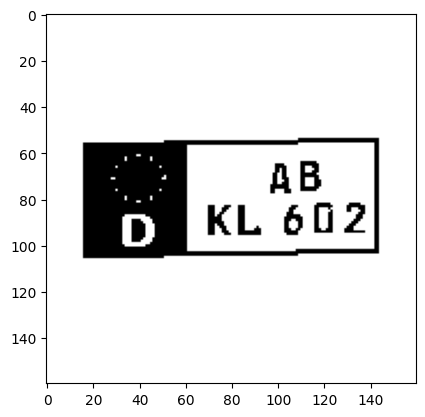

In [35]:
plt.imshow(images[0], cmap="gray")
plt.show()

Image with all detected contours: 


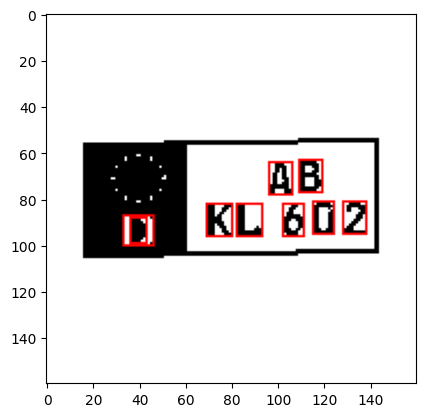

Image after removing too small contours: 


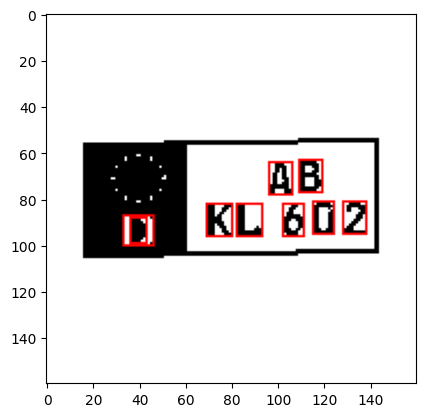

Image after removing letter D and all overlapping with it contours: 


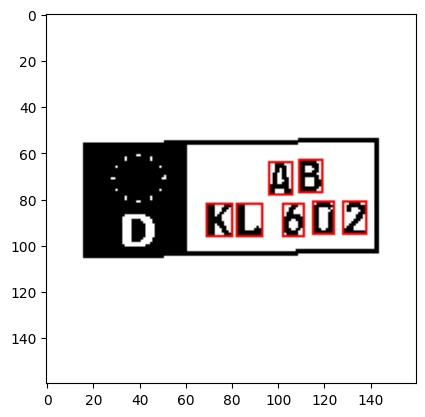

Image after removing all overlapping contours: 


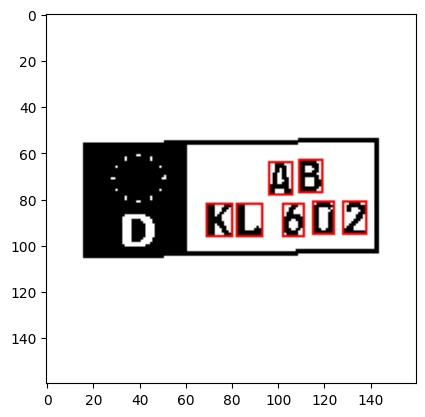

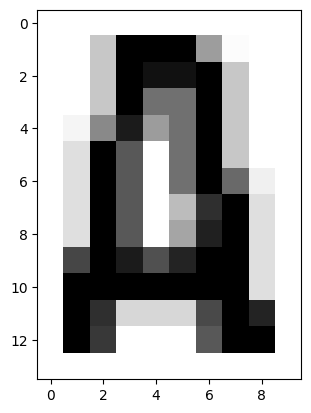

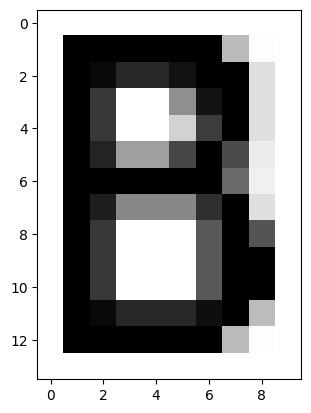

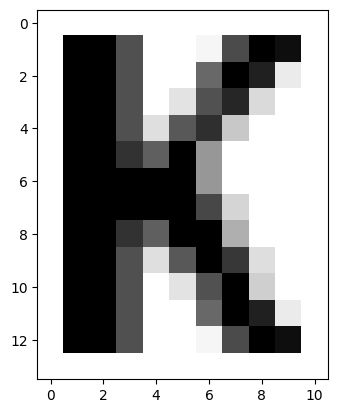

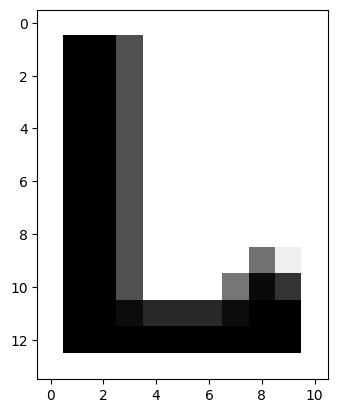

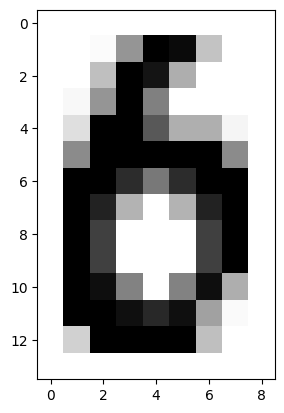

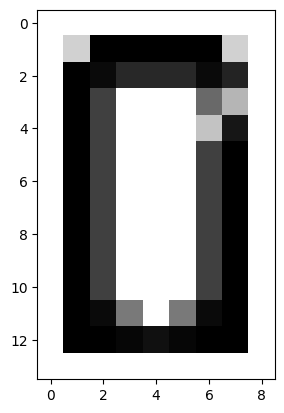

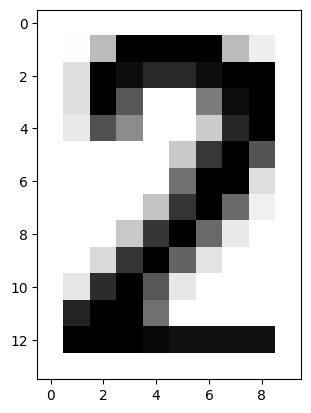

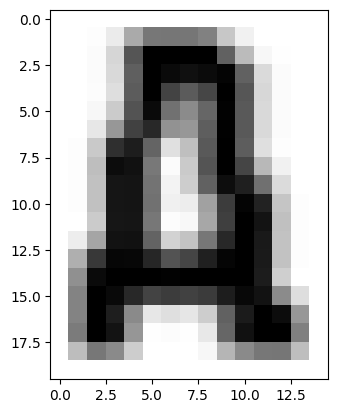

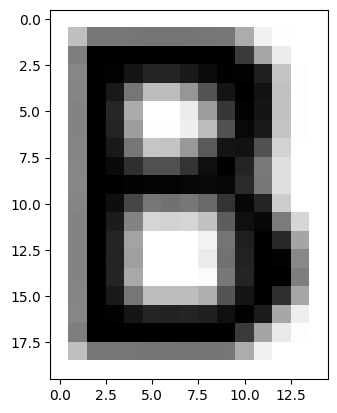

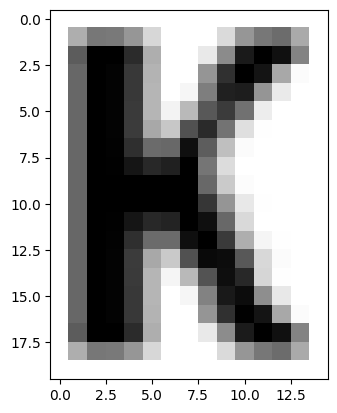

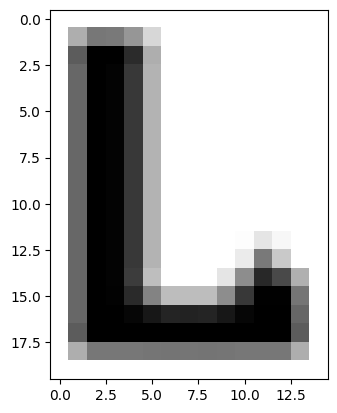

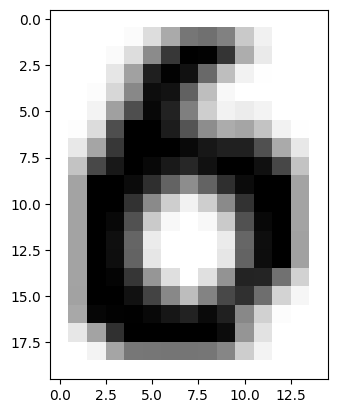

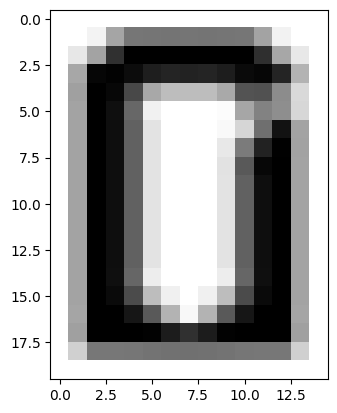

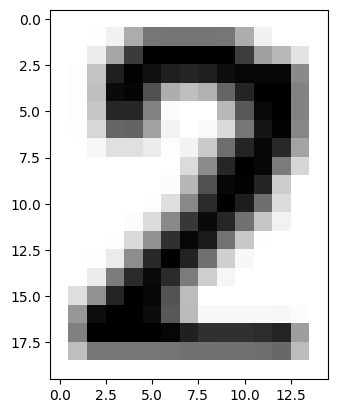

Image number  0
Real text:  ABKL6021
Predicted text:  ABKL602


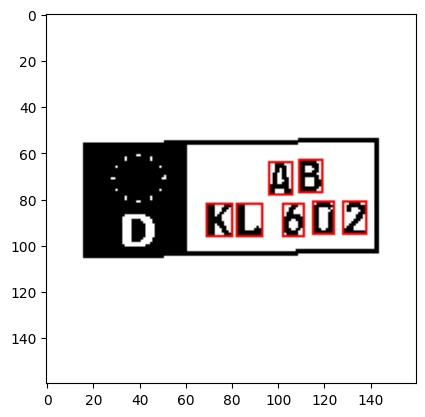

In [39]:
i = 0 # 21 # 8
image = images[i]
img_with_contours, predicted_text = detect_lp(image)
text = images_platenames[i][0:images_platenames[i].find('.')]

print("Image number ", i)
print("Real text: ", text)
print("Predicted text: ", predicted_text)
plt.imshow(img_with_contours)
plt.show()

Image with all detected contours: 


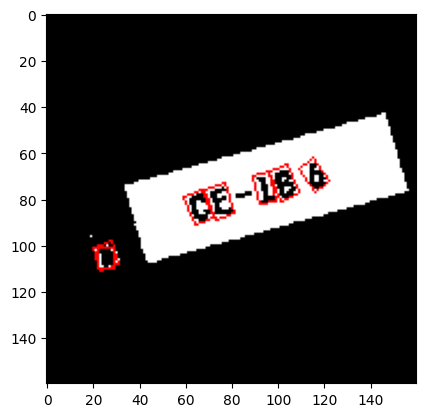

Image after removing too small contours: 


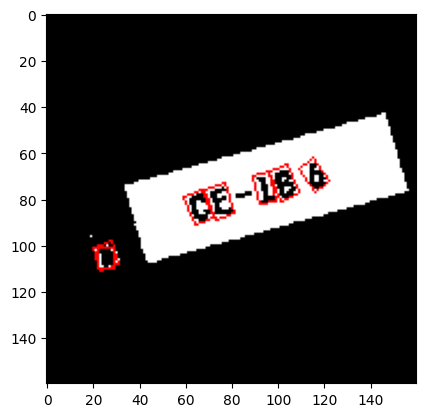

Image after removing letter D and all overlapping with it contours: 


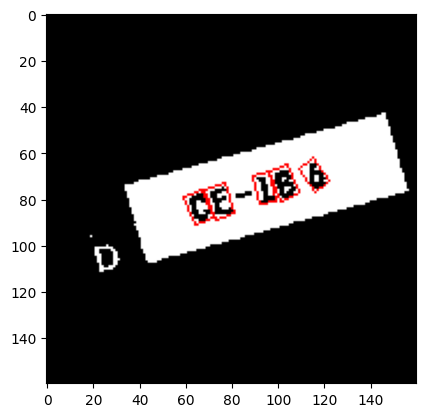

Image after removing all overlapping contours: 


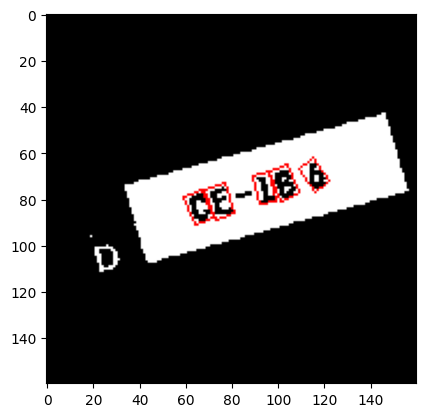

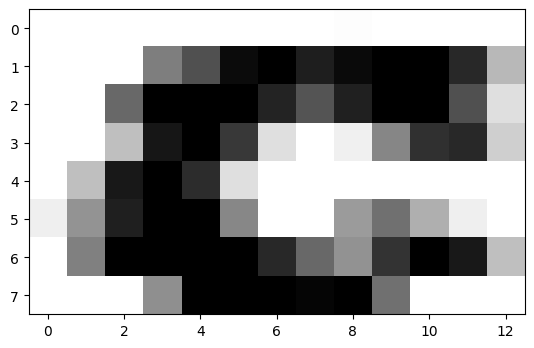

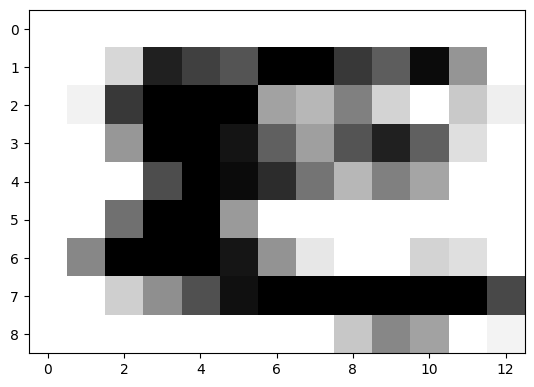

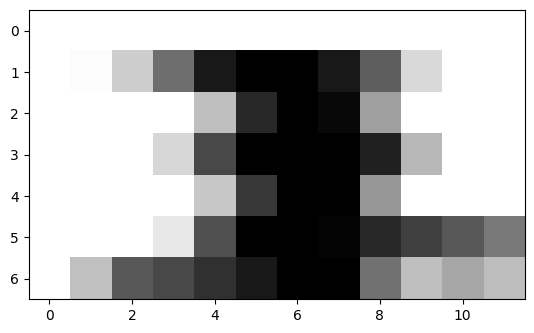

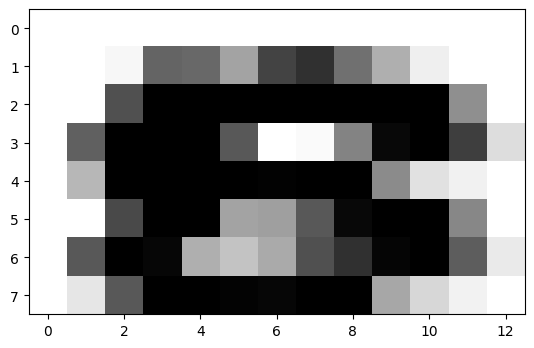

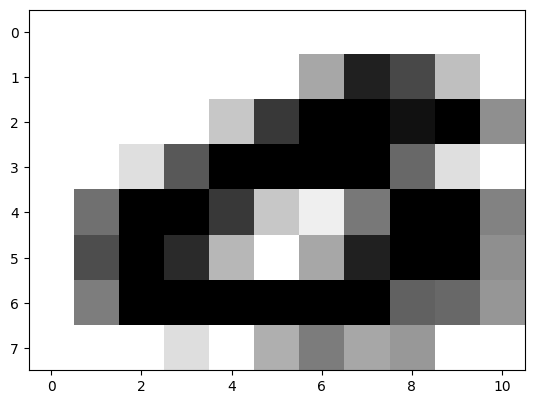

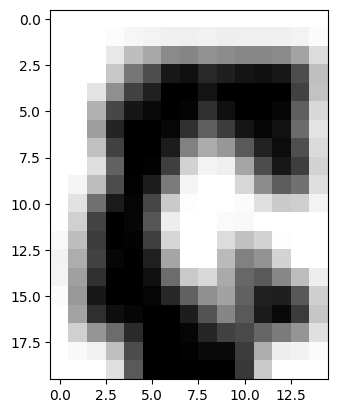

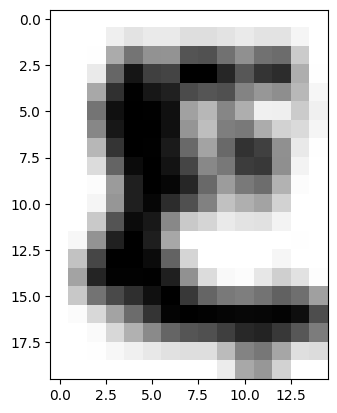

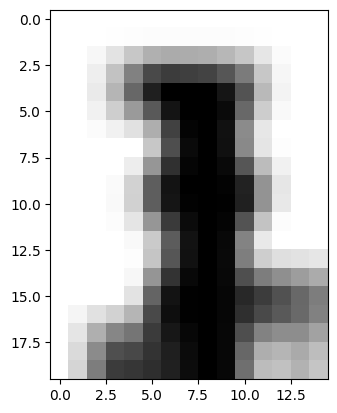

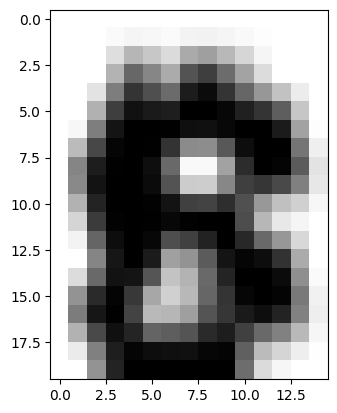

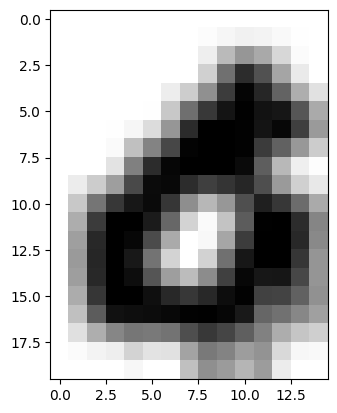

Image number  13
Real text:  CE-IB6
Predicted text:  CE184


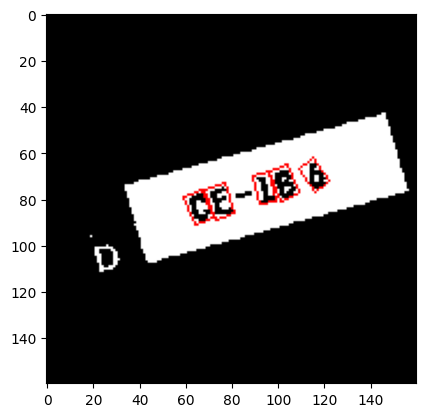

In [41]:
i = 13 # 21 # 8
image = images[i]
img_with_contours, predicted_text = detect_lp(image)
text = images_platenames[i][0:images_platenames[i].find('.')]

print("Image number ", i)
print("Real text: ", text)
print("Predicted text: ", predicted_text)
plt.imshow(img_with_contours)
plt.show()

adding dash because of dimensions:  3.1622774600982666 8.221921920776367
Image number  0
Real text:  A-U085
Predicted text:  A-U085
Image number  1
Real text:  AGQ0452
Predicted text:  AGQ0457
Image number  2
Real text:  AOQ3
Predicted text:  DA30
Image number  3
Real text:  AWF20
Predicted text:  AWR20
Image number  4
Real text:  BCOUE257
Predicted text:  BCQD62S2
Image number  5
Real text:  BEGU4
Predicted text:  BTGQ4
Image number  6
Real text:  BFK568
Predicted text:  BFX568
adding dash because of dimensions:  9.0 4.0
Image number  7
Real text:  CDI-OL097
Predicted text:  CD6-OLQ97
Image number  8
Real text:  CTJ0
Predicted text:  CDJ0
adding dash because of dimensions:  9.0 3.0
Image number  9
Real text:  D-J198
Predicted text:  D-J198
Image number  10
Real text:  DIZFP6
Predicted text:  DDZFP6
Image number  11
Real text:  DJWB40
Predicted text:  W8J4D0
Image number  12
Real text:  EBYK1
Predicted text:  IVAX8
Image number  13
Real text:  EGXTD1
Predicted text:  EGXTD1
Image numbe

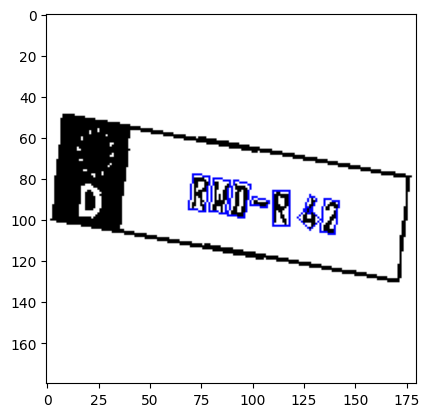

Image number  67
Real text:  SIZW399
Predicted text:  S12W399
adding dash because of dimensions:  3.4785051345825195 9.17060375213623
Image number  68
Real text:  SSG-N93
Predicted text:  SSO-N93
Image number  69
Real text:  SWQ780
Predicted text:  SWQ760
adding dash because of dimensions:  8.221921920776367 3.4785051345825195
Image number  70
Real text:  SX-J546
Predicted text:  SX-J5A6
adding dash because of dimensions:  8.221921920776367 3.1622776985168457
Image number  71
Real text:  SZY-Q0
Predicted text:  SZI-O0
adding dash because of dimensions:  3.1622774600982666 8.221921920776367
Image number  72
Real text:  T-PH532
Predicted text:  T-PH532
Image number  73
Real text:  TWPP66
Predicted text:  TWPP66
adding dash because of dimensions:  3.781176805496216 9.206343650817871
Image number  74
Real text:  U-AL515
Predicted text:  U-AL515
Image number  75
Real text:  UBOK3044
Predicted text:  D8OX30M4
Image number  76
Real text:  UPZ5
Predicted text:  UBZ5
Image number  77
Real text:

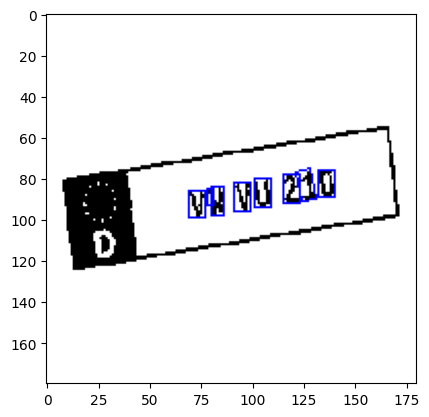

adding dash because of dimensions:  3.152963161468506 7.276068687438965
Image number  82
Real text:  WH-HJ8
Predicted text:  WH-WJ8
adding dash because of dimensions:  8.0 3.0
Image number  83
Real text:  WL-UG73
Predicted text:  NU-0B13
Image number  84
Real text:  WPSKF7382
Predicted text:  KPSKTT382
Image number  85
Real text:  WRIB440
Predicted text:  V9I8W40
adding dash because of dimensions:  9.0 3.0
Image number  86
Real text:  WWP-SE06
Predicted text:  VVP-S8Q6
Image number  87
Real text:  WXR33
Predicted text:  KXP33
adding dash because of dimensions:  8.0 3.0
adding dash because of dimensions:  3.6380343437194824 21.3431339263916
Image number  88
Real text:  X-QB27
Predicted text:  X-O827-4

 Length is different!


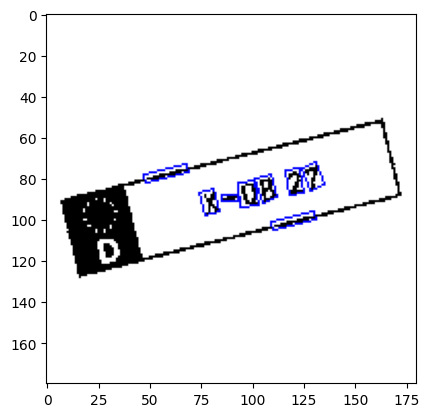

Image number  89
Real text:  XLD85
Predicted text:  X4Q85
Image number  90
Real text:  XQX0
Predicted text:  XQX0
Image number  91
Real text:  XT1714
Predicted text:  DI1IX4
adding dash because of dimensions:  8.219949722290039 3.7811765670776367
Image number  92
Real text:  Y-AJ884
Predicted text:  I-AJ881
adding dash because of dimensions:  3.6380343437194824 8.246211051940918
Image number  93
Real text:  Y-TK542
Predicted text:  H-YX542
Image number  94
Real text:  YKQS702
Predicted text:  OSMX1O2
Image number  95
Real text:  YO7
Predicted text:  KO0
Image number  96
Real text:  YU1
Predicted text:  IU1
Image number  97
Real text:  YUKPZ35
Predicted text:  IUXPZ35
Image number  98
Real text:  ZDVY155
Predicted text:  ZDVY155
Image number  99
Real text:  ZMV578
Predicted text:  ZMV578
avg_percent_of_correct_placed_chars:  0.6140476190476192
avg_length_identical_percent:  0.97
avg_text_identical_percent:  0.12


In [13]:
test_size = 100
misident_dict = {}
char_occurence_freq_dict = {}
avg_percent_of_correct_placed_chars = 0.0
avg_length_identical = 0
avg_text_identical = 0

for i, image in enumerate(images):
        img_with_contours, predicted_text = detect_lp(image)
        text = images_platenames[i][0:images_platenames[i].find('.')]
    
        print("Image number ", i)
        print("Real text: ", text)
        print("Predicted text: ", predicted_text)
    
        for c_pos, c in enumerate(text):
            if (len(predicted_text)>c_pos and predicted_text[c_pos]!=c):
                if c not in misident_dict:
                    misident_dict[c] = [predicted_text[c_pos]]
                else:
                    misident_dict[c].append(predicted_text[c_pos])
            if c not in char_occurence_freq_dict:
                char_occurence_freq_dict[c] = 0
            else:
                char_occurence_freq_dict[c] = char_occurence_freq_dict[c]+1
    
        avg_percent_of_correct_placed_chars += metrics.get_correct_placed_chars_percent(text, predicted_text)
        avg_length_identical += metrics.is_length_same(text, predicted_text)
        avg_text_identical +=  metrics.is_text_same(text, predicted_text)
    
        if (metrics.is_length_same(text, predicted_text) == False):
            print("\n Length is different!")
            plt.imshow(img_with_contours)
            plt.show()
    
        if i >= test_size - 1:
            break
    
avg_percent_of_correct_placed_chars /= test_size
avg_length_identical_percent = avg_length_identical / test_size
avg_text_identical_percent = avg_text_identical / test_size
print("avg_percent_of_correct_placed_chars: ", avg_percent_of_correct_placed_chars)
print("avg_length_identical_percent: ", avg_length_identical_percent)
print("avg_text_identical_percent: ", avg_text_identical_percent)

In [59]:
misident_dict
# avg_percent_of_correct_placed_chars:  0.7325595238095236
# avg_length_identical_percent:  0.97
# avg_text_identical_percent:  0.18

{'J': ['I', 'I', 'I', '3', '3', '3'],
 'A': ['P', 'N', '4', '4', '4', '4', 'N', 'N', 'N', '4'],
 'Y': ['M', 'M', 'K', 'H', 'M', 'N', 'M'],
 'K': ['X', 'X', 'H', 'X'],
 'W': ['V', 'K', 'V', 'N'],
 'P': ['0', 'O', 'D'],
 'V': ['Y', 'Y', 'K', 'W', 'W', 'L', 'W'],
 '5': ['S', 'B'],
 '6': ['5', '4', 'O', 'Q', '5'],
 'B': ['8', '8', '8', '8', '8', '8', '8'],
 '7': ['4',
  '1',
  'J',
  '0',
  '0',
  'Z',
  '3',
  '1',
  'I',
  '0',
  '1',
  '0',
  '1',
  'J',
  '1',
  '4'],
 'G': ['B', '0', '8', 'B'],
 'R': ['P', 'P', '8', 'P'],
 '4': ['F',
  '9',
  'L',
  '0',
  'W',
  '0',
  'L',
  '0',
  'P',
  'W',
  '0',
  '6',
  '0',
  '9',
  '7'],
 'O': ['Q', '0', '0', 'Q', 'Q', 'Q', 'Q', 'Q', '0', 'Q', 'Q', 'Q', '0'],
 '9': ['J', '3', 'J', '4', 'D'],
 'D': ['0', '0', 'Q', 'Q', '0'],
 'Q': ['0', '0', 'C', 'Z'],
 'T': ['D', 'D', 'D', 'D', 'D', 'D', 'C', 'D'],
 'I': ['D', 'D', 'D', 'D', 'D', '1', 'J', '1', 'D', 'D'],
 'U': ['0', 'B'],
 'N': ['M', 'M', 'M'],
 '1': ['I', 'I', 'I', 'I', '2', 'I', 'I', 'I',

In [60]:
misident_nonrepeated_dict = {}
for key in misident_dict:
    misident_nonrepeated_dict[key] = list(dict.fromkeys(misident_dict[key]))

In [61]:
misident_nonrepeated_dict

{'J': ['I', '3'],
 'A': ['P', 'N', '4'],
 'Y': ['M', 'K', 'H', 'N'],
 'K': ['X', 'H'],
 'W': ['V', 'K', 'N'],
 'P': ['0', 'O', 'D'],
 'V': ['Y', 'K', 'W', 'L'],
 '5': ['S', 'B'],
 '6': ['5', '4', 'O', 'Q'],
 'B': ['8'],
 '7': ['4', '1', 'J', '0', 'Z', '3', 'I'],
 'G': ['B', '0', '8'],
 'R': ['P', '8'],
 '4': ['F', '9', 'L', '0', 'W', 'P', '6', '7'],
 'O': ['Q', '0'],
 '9': ['J', '3', '4', 'D'],
 'D': ['0', 'Q'],
 'Q': ['0', 'C', 'Z'],
 'T': ['D', 'C'],
 'I': ['D', '1', 'J'],
 'U': ['0', 'B'],
 'N': ['M'],
 '1': ['I', '2'],
 'H': ['M', 'O', 'B'],
 '0': ['K', 'O'],
 'L': ['W', 'A', 'Y'],
 '2': ['Z'],
 '8': ['B'],
 'C': ['Q'],
 'Z': ['Q']}

In [62]:
char_occurence_freq_dict

{'A': 17,
 'J': 20,
 'N': 16,
 '5': 24,
 'X': 10,
 'Y': 12,
 'K': 11,
 'W': 10,
 '2': 27,
 'B': 20,
 'P': 10,
 'Z': 9,
 'V': 16,
 '9': 21,
 'R': 19,
 'L': 17,
 '6': 29,
 '7': 32,
 'C': 20,
 '-': 20,
 'E': 12,
 '0': 22,
 'Q': 19,
 '3': 15,
 '1': 19,
 'M': 14,
 'D': 7,
 'G': 12,
 'F': 18,
 '8': 22,
 '4': 21,
 'S': 12,
 'O': 13,
 'H': 11,
 'T': 12,
 'I': 15,
 'U': 7}

In [63]:
misident_dict

{'J': ['I', 'I', 'I', '3', '3', '3'],
 'A': ['P', 'N', '4', '4', '4', '4', 'N', 'N', 'N', '4'],
 'Y': ['M', 'M', 'K', 'H', 'M', 'N', 'M'],
 'K': ['X', 'X', 'H', 'X'],
 'W': ['V', 'K', 'V', 'N'],
 'P': ['0', 'O', 'D'],
 'V': ['Y', 'Y', 'K', 'W', 'W', 'L', 'W'],
 '5': ['S', 'B'],
 '6': ['5', '4', 'O', 'Q', '5'],
 'B': ['8', '8', '8', '8', '8', '8', '8'],
 '7': ['4',
  '1',
  'J',
  '0',
  '0',
  'Z',
  '3',
  '1',
  'I',
  '0',
  '1',
  '0',
  '1',
  'J',
  '1',
  '4'],
 'G': ['B', '0', '8', 'B'],
 'R': ['P', 'P', '8', 'P'],
 '4': ['F',
  '9',
  'L',
  '0',
  'W',
  '0',
  'L',
  '0',
  'P',
  'W',
  '0',
  '6',
  '0',
  '9',
  '7'],
 'O': ['Q', '0', '0', 'Q', 'Q', 'Q', 'Q', 'Q', '0', 'Q', 'Q', 'Q', '0'],
 '9': ['J', '3', 'J', '4', 'D'],
 'D': ['0', '0', 'Q', 'Q', '0'],
 'Q': ['0', '0', 'C', 'Z'],
 'T': ['D', 'D', 'D', 'D', 'D', 'D', 'C', 'D'],
 'I': ['D', 'D', 'D', 'D', 'D', '1', 'J', '1', 'D', 'D'],
 'U': ['0', 'B'],
 'N': ['M', 'M', 'M'],
 '1': ['I', 'I', 'I', 'I', '2', 'I', 'I', 'I',

Text(0.5, 1.0, 'Frequency of misinterpreting symbols')

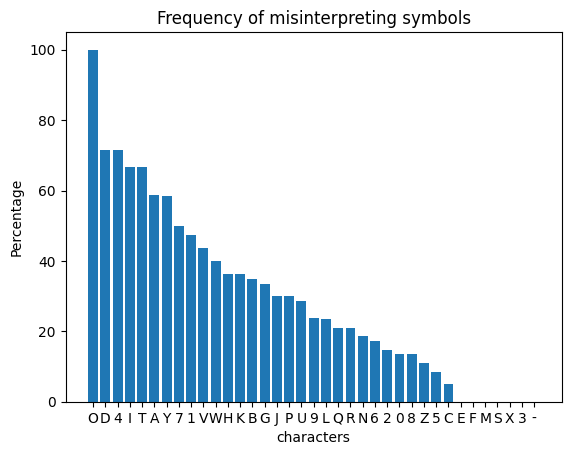

In [75]:
from operator import itemgetter
x = string.ascii_uppercase+string.digits+"-"
misident_freq_list = {}
for char in x:
    if char in misident_dict:
        misident_freq_list[char]=(len(misident_dict[char])/char_occurence_freq_dict[char])*100
    else:
        misident_freq_list[char] = 0
lists = sorted(misident_freq_list.items(),key=lambda x: x[1], reverse=True)
labels, values = zip(*lists) # unpack a list of pairs into two tuples

plt.bar(labels, [value for value in values])
plt.xlabel("characters")
plt.ylabel("Percentage")
plt.title("Frequency of misinterpreting symbols")

In [76]:
misident_dict['O']

['Q', '0', '0', 'Q', 'Q', 'Q', 'Q', 'Q', '0', 'Q', 'Q', 'Q', '0']

In [74]:
len(misident_dict['O'])*100/char_occurence_freq_dict['O']

100.0